# Multilayer Perceptrons

This Notebook covers a few simple MLP models using Keras, as well as an AutoML model using H2o.ai. This notebook covers various datasets, some more suitable for ANNs than others. 

For the first dataset, the models attempt to predict diabetes using the Pima Indians dataset. This is a standard machine learning dataset sourced from the UCI Machine Learning repository. It describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years.

Features:
1. Number of times pregnant.
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test. 3. Diastolic blood pressure (mm Hg).
4. Triceps skin fold thickness (mm).
5. 2-Hour serum insulin (mu U/ml).
6. Body mass index.
7. Diabetes pedigree function.
8. Age (years).
9. Class, onset of diabetes within five years.

## Import Libraries

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dropout

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

import time

%matplotlib inline

## Load Data

In [26]:
def load_data(location, target_last = True, target = None):
    data = pd.read_csv('data/pima-indians-diabetes.csv', header = -1)
    t = data.shape[1] - 1
    X = data.drop(t,axis = 1).as_matrix()
    Y = data[t].as_matrix()
    return X, Y, data

In [27]:
X,Y, data = load_data(location = 'data/pima-indians-diabetes.csv')

In [28]:
data.shape

(768, 9)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=11)

## Pairplot

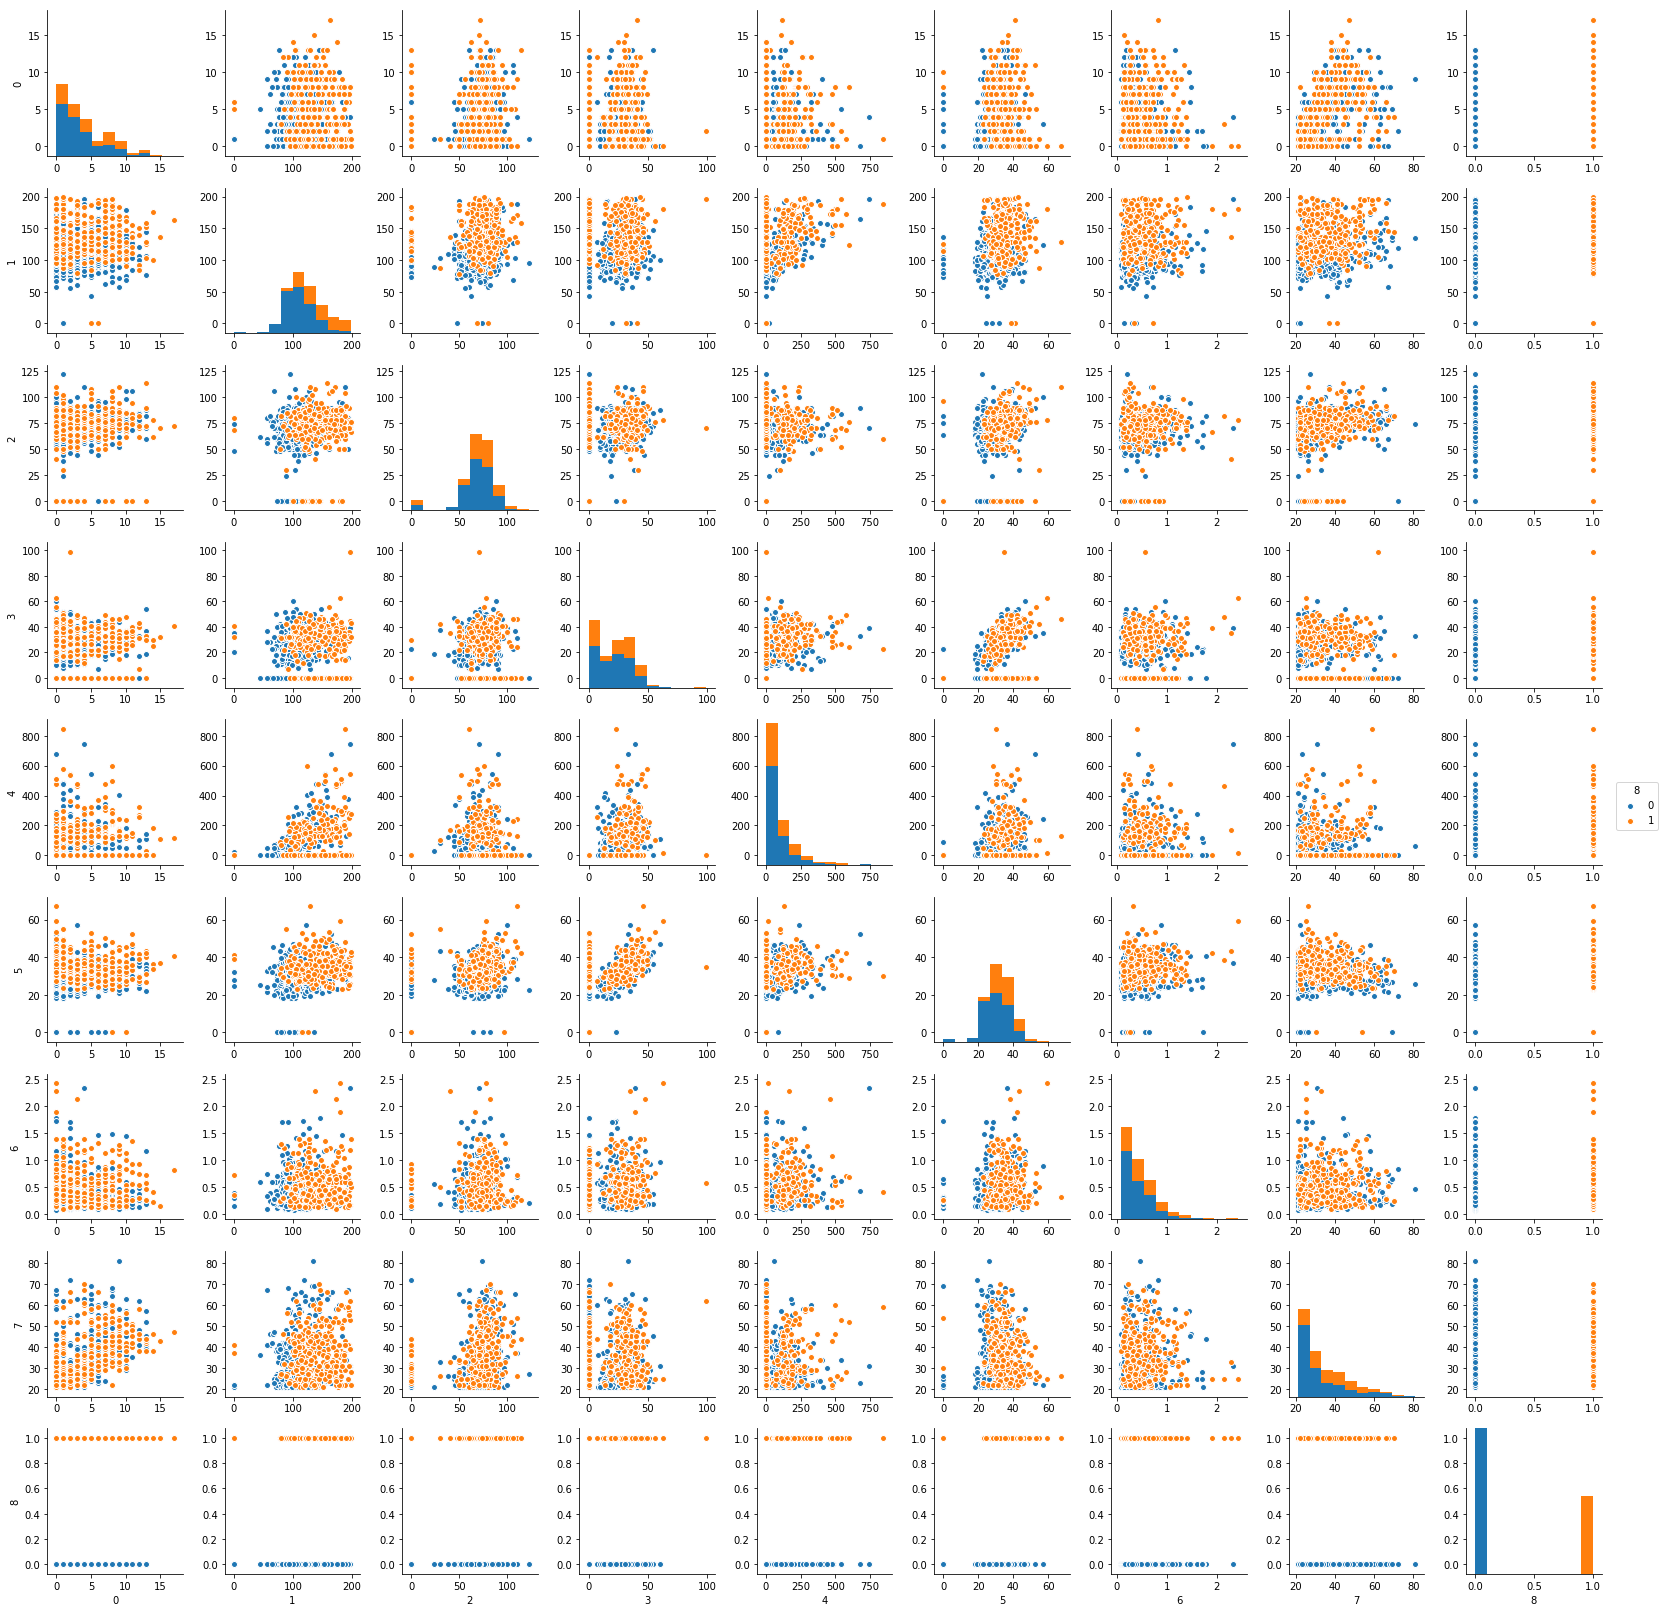

In [7]:
sns.pairplot(data,hue = 8)

## Keras

In [7]:
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17196727149414541904
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 78643200
locality {
  bus_id: 1
}
incarnation: 1022922827209069281
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0"
]


#### MLP using Keras Validation

In [69]:
model = Sequential()
model.add(Dense(12, input_dim = 8 , activation= 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##### Graph of training

In [70]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=8,verbose= 0)

In [71]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

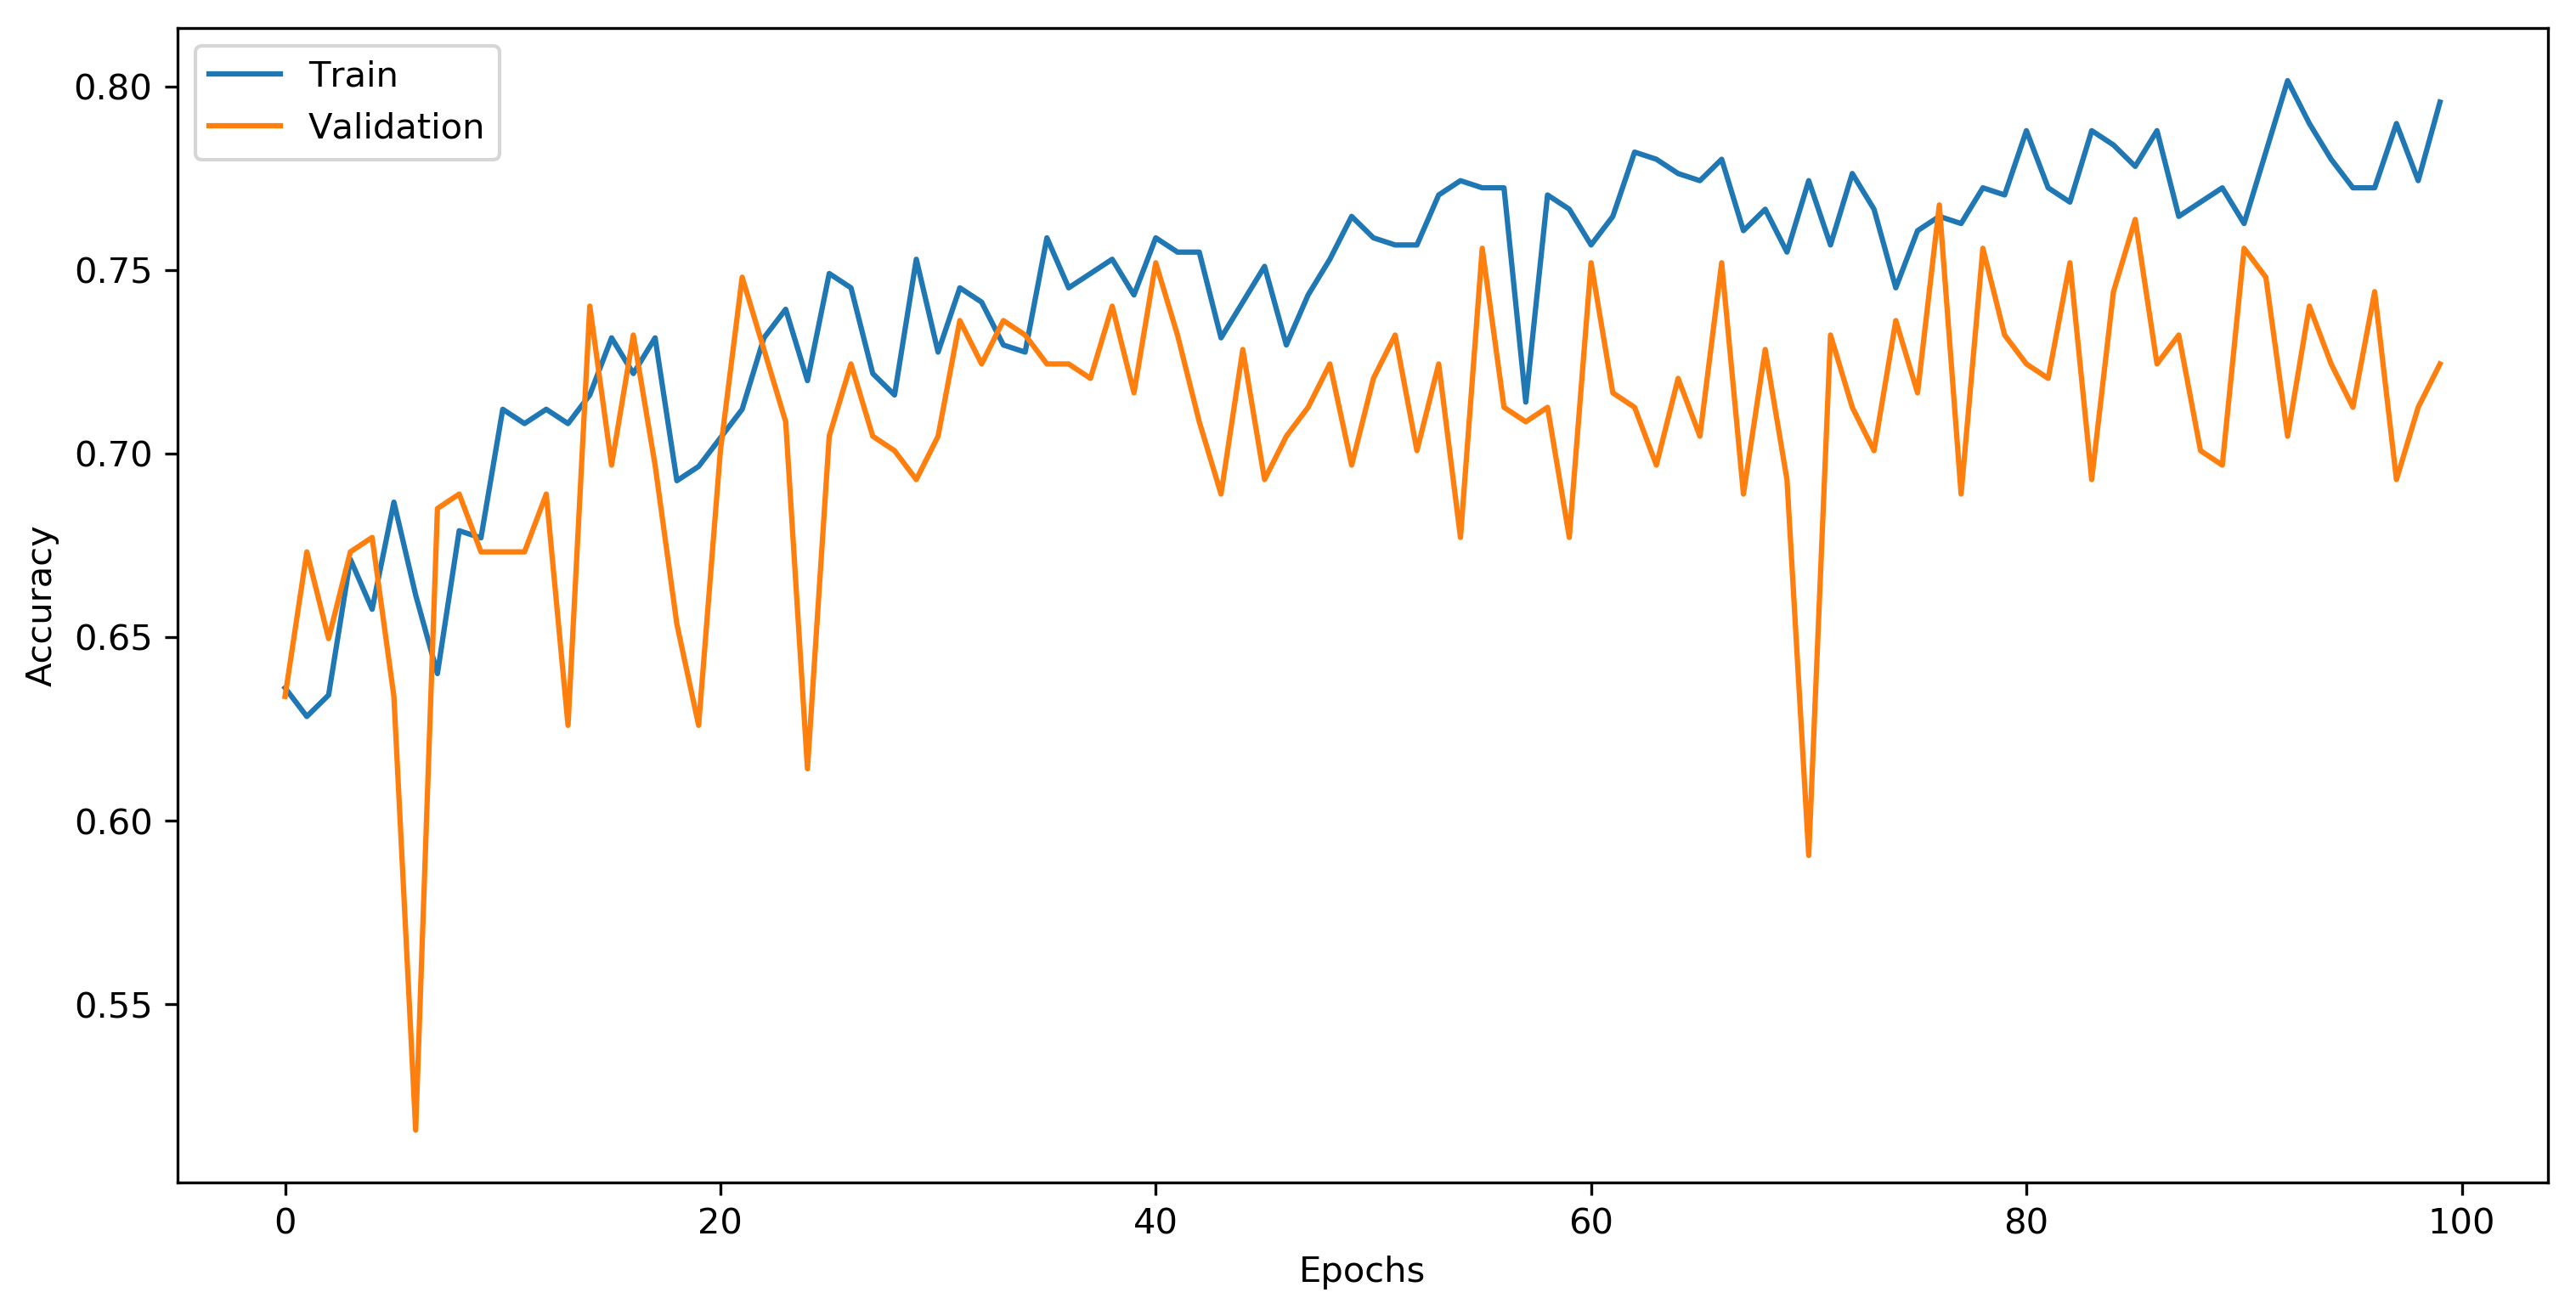

In [77]:
fig, ax = plt.subplots(figsize = (12,6),dpi = 300)
ax.plot(history.history['acc'],label = 'Train')
ax.plot(history.history['val_acc'], label = 'Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.legend();

#### Predictions

In [78]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=250, batch_size=50,verbose= 0)

In [79]:
pred = model.predict_classes(X_test)

 32/254 [==>...........................] - ETA: 0s

In [80]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.75      0.91      0.82       165
          1       0.72      0.44      0.55        89

avg / total       0.74      0.74      0.73       254



#### MLP using SKlearn Wrapper

In [21]:
def build():
    model = Sequential()
    model.add(Dense(12,activation = 'relu',input_dim = 8))
    model.add(Dense(10,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
model = KerasClassifier(build_fn=build,epochs=150, batch_size=10,verbose= 0)

In [23]:
kfolds = StratifiedKFold(n_splits = 5,shuffle=True, random_state= 11)

In [24]:
kf_results = cross_val_score(model,X,Y,cv = kfolds)

In [25]:
print (kf_results.mean())

0.690111198446


#### MLP using SKlearn Wrapper - Grid Search

In [11]:
def build(init, opti,n):
    model = Sequential()
    model.add(Dense(12,kernel_initializer=init, activation = 'relu',input_dim = 8))
    model.add(Dense(n,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    return model

In [12]:
model = KerasClassifier(build_fn=build, verbose = 0)

In [13]:
init = ['normal','uniform']
opti = ['adam','rmsprop']
n = [8,15,30]
epochs = [150,250]
batches = [10,50]

In [14]:
params = dict(init = init, opti = opti, n = n, epochs = epochs, batch_size = batches)

In [18]:
grid = GridSearchCV(model,param_grid=params)

In [19]:
results = grid.fit(X,Y)

In [20]:
grid.best_score_

0.75390626047737896

In [21]:
grid.best_params_

{'batch_size': 10, 'epochs': 250, 'init': 'normal', 'n': 30, 'opti': 'adam'}

## H20

In [10]:
import h2o as h
from h2o.automl import H2OAutoML

In [11]:
h.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------------
H2O cluster uptime:         12 days 10 hours 37 mins
H2O cluster version:        3.15.0.4068
H2O cluster version age:    28 days, 19 hours and 34 minutes
H2O cluster name:           H2O_from_python_mrd_3apsmf
H2O cluster total nodes:    1
H2O cluster free memory:    3.204 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.3 final
--------------------------  ----------------------------------------

In [12]:
data = data.rename_axis({0:'0',1:'1',2:'2',3:"3",4:"4",5:'5',6:'6',7:'7',8:'target'},axis=1)

In [13]:
hf = h.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
train, valid, test = hf.split_frame([.7,.15],seed = 1234)
X = hf.col_names
X.remove('target')
y = 'target'

In [15]:
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [195]:
aml = H2OAutoML()
aml.train(x = X, y = y,training_frame = train,leaderboard_frame = valid)
lb = aml.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [196]:
lb

model_id auc logloss 
 
 
 XRT_0_AutoML_20171103_100208 0.808635 0.498467 
 DeepLearning_0_AutoML_20171103_100726 0.796908 0.485258 
 StackedEnsemble_0_AutoML_20171103_100726 0.796908 0.512507 
 StackedEnsemble_0_AutoML_20171103_100208 0.786247 0.521921 
 DRF_0_AutoML_20171103_100726 0.784382 0.489834 
 XRT_0_AutoML_20171103_100726 0.772921 0.513182 
 DeepLearning_0_AutoML_20171103_100208 0.75693 0.542564 
 DRF_0_AutoML_20171103_100208 0.726546 0.926096

In [197]:
m = aml.leader

In [198]:
t = m.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [199]:
pred = t.as_data_frame()['predict']
true = test.as_data_frame()['target']

In [200]:
print(classification_report(true,pred.values))

             precision    recall  f1-score   support

          0       0.90      0.76      0.82        80
          1       0.66      0.84      0.74        44

avg / total       0.81      0.79      0.79       124



#### H20 Deeplearning Grid Search

In [20]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

In [26]:
# DL hyperparameters
# activation_opt = ["Rectifier", "RectifierWithDropout", "Maxout", "MaxoutWithDropout"]
l1_opt = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
l2_opt = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1]
dl_params = { 'l1': l1_opt, 'l2': l2_opt}

# Search criteria
search_criterias = {'strategy': 'RandomDiscrete', 'max_runtime_secs': 120, 'seed':1}

In [ ]:
# dl_grid = H2OGridSearch(model=H2ODeepLearningEstimator,
#                         grid_id='dl_grid1',
#                         hyper_params=dl_params,
#                         search_criteria=search_criteria)

# dl_grid.train(x=X, y=y,
#               training_frame=train, 
#               validation_frame=valid, 
#               hidden=[10,10])

# dl_gridperf = dl_grid.get_grid(sort_by='auc', decreasing=True)

## Iris Dataset 

In [10]:
data = pd.read_csv('data/iris.csv',header = None)
X = data.iloc[:,0:4].as_matrix()
y = data[4].as_matrix()

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)
y= to_categorical(y)

In [12]:
def build(n1,n2):
    model = Sequential()
    model.add(Dense(n1,input_dim = 4, activation='relu'))
    model.add(Dense(n2, activation='relu'))
    model.add(Dense(3,activation='softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
    return model

In [13]:
kc = KerasClassifier(build_fn=build,verbose = 0)

In [14]:
kfold = KFold(n_splits=10,shuffle=True,random_state=33)

In [15]:
n1 = [4,8,10]
n2 = [10,20,50]
params = dict(n1=n1,n2=n2)

In [17]:
grid = GridSearchCV(kc,cv =kfold, param_grid= params)

In [18]:
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=10, random_state=33, shuffle=True),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1c1ffa33c8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n1': [4, 8, 10], 'n2': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
best = build(8,50)

In [29]:
best.fit(X,y, epochs= 1000,verbose=0)

In [33]:
best.evaluate(X,y,batch_size=50)

 50/150 [=========>....................] - ETA: 0s

[0.0452689047591169, 0.98666667938232422]

## Sonar Dataset

In [82]:
data = pd.read_csv('data/sonar.csv',header = None)

In [83]:
X = data.iloc[:,:60].as_matrix()
y = data[60].as_matrix()

In [88]:
le = LabelEncoder()
Y = le.fit_transform(y)

In [89]:
def build():
    model = Sequential()
    model.add(Dense(30,input_dim = 60, kernel_initializer = 'normal', activation='relu'))
    model.add(Dense(1,kernel_initializer = 'normal', activation='sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
    return model

In [90]:
kc = KerasClassifier(build_fn=build,epochs=100,batch_size = 5,verbose=0)

In [91]:
pipeline = Pipeline([('scaler',StandardScaler()),('mlp',kc)])

In [92]:
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)

In [93]:
cross_val_score(pipeline,X,y,cv=kfold).mean()

0.84110390445725491

### Sonar with Dropouts and Constraints

In [146]:
model = Sequential()
model.add(Dense(30,input_dim = 60, kernel_initializer = 'normal', activation='relu',kernel_constraint=maxnorm(4)))
model.add(Dropout(.2))
model.add(Dense(1,kernel_initializer = 'normal', activation='sigmoid',kernel_constraint=maxnorm(4)))
sgd = SGD(momentum=.9)
model.compile(optimizer = sgd, loss = 'binary_crossentropy',metrics=['accuracy'])

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 20)

In [148]:
model.fit(X_train,y_train,epochs = 450, batch_size = 10,verbose = 0)

In [149]:
print (classification_report(y_test,model.predict_classes(X_test)))

32/52 [=================>............] - ETA: 0s             precision    recall  f1-score   support

          0       0.83      0.91      0.87        32
          1       0.82      0.70      0.76        20

avg / total       0.83      0.83      0.82        52



## Boston Housing Prices

In [159]:
data = pd.read_csv('data/housing.csv',delim_whitespace=True,header=None)
X = data.values[:,0:13]
y = data.values[:,13]

In [160]:
def build():
    model = Sequential()
    model.add(Dense(20,input_dim = 13, kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(8,kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

In [161]:
model = KerasRegressor(build_fn=build,epochs = 200, batch_size = 10,verbose = 0)

In [162]:
# checkpoint = ModelCheckpoint('data/_checkpoint/boston',monitor = 'loss',save_best_only=True,save_weights_only=False, period=1)
# cplist = [checkpoint]

In [163]:
pipeline = Pipeline([('Standardize',StandardScaler()),('MLP',model)])

In [164]:
kfolds = KFold(n_splits=5,shuffle=True,random_state=11)

In [9]:
# output = cross_val_score(pipeline,X,y,cv=kfolds,n_jobs=-1,fit_params={'MLP__callbacks':cplist})
output = cross_val_score(pipeline,X,y,cv=kfolds,n_jobs=-1)

In [10]:
np.sqrt(output.mean())

3.4373234708962976

### Train/Test

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 20)

In [166]:
# checkpoint2 = ModelCheckpoint('data/_checkpoint/boston2',monitor = 'loss',save_best_only=True,save_weights_only=True)
# cplist2 = [checkpoint2]

In [167]:
# pipeline.fit(X_train, y_train, fit_params={'MLP__callbacks':cplist2})
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('Standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('MLP', <keras.wrappers.scikit_learn.KerasRegressor object at 0x1c379a0358>)])

In [168]:
pred = pipeline.predict(X_test)

In [169]:
np.sqrt(mse(y_test, pred))

3.4695156195960246

### Save / Load Model

In [172]:
pipeline.named_steps['MLP'].model.save('data/_pickle/mlp')
pd.to_pickle(pipeline.named_steps['Standardize'],'data/_pickle/ss')

In [173]:
mlp = load_model('data/_pickle/mlp')
ss = pd.read_pickle('data/_pickle/ss')

In [174]:
pipeline2 = Pipeline([('Standardize',ss),('MLP',mlp)])

In [175]:
pred = pipeline2.predict(X_test)

In [176]:
np.sqrt(mse(y_test, pred))

3.4695156195960246